In [21]:
### Cell 1 ###
import numpy as np
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

# Paths (adapt these only if your folder changes)
INTEGRATED_PATH = r"C:/Users/HP/OneDrive/Desktop/VERO_code/Phase_3/phase3_outputs/phase3_integrated_data.csv"
TYPES_PATH = r"C:/Users/HP/OneDrive/Desktop/VERO_code/Phase_2/results/tables/features_data_types.xlsx"
OUTCOME_PATH = r"C:/Users/HP/OneDrive/Desktop/VERO_code/Phase_2/results/tables/outcome.csv"

OUT_DIR = Path(r"C:/Users/HP/OneDrive/Desktop/VERO_code/Phase_3/phase3_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Load data
df = pd.read_csv(INTEGRATED_PATH)
types_raw = pd.read_excel(TYPES_PATH)

print("Base cohort shape:", df.shape)

# Identify patient ID column
id_candidates = [c for c in df.columns if re.search(r"(patient.*id|id.*patient|^id$)", c, flags=re.I)]
id_col = id_candidates[0] if id_candidates else None
print("Detected patient ID column:", id_col)

# Remove explicit outcome variables from clustering features
exclude_outcome = ["survival_days", "Overall_Survival", "Death", "death_during_observation"]
exclude = [id_col] + [c for c in exclude_outcome if c in df.columns]

feature_cols = [c for c in df.columns if c not in exclude]
print("Initial feature cols for clustering:", len(feature_cols))


Base cohort shape: (403, 46)
Detected patient ID column: patient_id
Initial feature cols for clustering: 44


In [22]:
### Cell 2 ###
import numpy as np
import pandas as pd

df_work = df.copy()

# Helper to encode ordered lab ranges robustly
def encode_ordered_range(series: pd.Series) -> pd.Series:
    """
    Encode lab ranges as ordinal:
    Low -> 0, Normal -> 1, High -> 2, Not known or missing -> -1.
    Falls back to simple pattern matching on text.
    """
    s = series.astype(str)
    s_lower = s.str.lower()

    encoded = pd.Series(index=s.index, dtype="float")

    # Not known or missing like categories
    mask_na = s_lower.str.contains("not", na=False) | s_lower.str.contains("missing", na=False)
    encoded[mask_na] = -1

    # Low
    mask_low = s_lower.str.contains("low", na=False) | s_lower.str.contains("<", na=False)
    encoded[mask_low & encoded.isna()] = 0

    # Normal
    mask_norm = s_lower.str.contains("norm", na=False)
    encoded[mask_norm & encoded.isna()] = 1

    # High
    mask_high = s_lower.str.contains("high", na=False) | s_lower.str.contains(">", na=False)
    encoded[mask_high & encoded.isna()] = 2

    # For anything else that did not match, leave as NaN
    return encoded

# Identify columns that look like range coded labs
range_like_cols = [c for c in df_work.columns if "range" in c.lower()]

print("Range like columns detected:", range_like_cols)

# Encode them to ordinal numeric where possible
for col in range_like_cols:
    encoded = encode_ordered_range(df_work[col])
    # If at least some non NaN appear, we keep the encoded version
    if encoded.notna().sum() > 0:
        df_work[col] = encoded
        print(f"Encoded ordered lab range as ordinal for: {col}")

df = df_work.copy()

Range like columns detected: ['white_blood_cells_range', 'neutrophils_percent_range', 'platelet_count_range', 'red_blood_cells_range', 'creatinine_range', 'hemoglobin_range', 'direct_bilirubin_range']
Encoded ordered lab range as ordinal for: white_blood_cells_range
Encoded ordered lab range as ordinal for: neutrophils_percent_range
Encoded ordered lab range as ordinal for: platelet_count_range
Encoded ordered lab range as ordinal for: red_blood_cells_range
Encoded ordered lab range as ordinal for: creatinine_range
Encoded ordered lab range as ordinal for: hemoglobin_range
Encoded ordered lab range as ordinal for: direct_bilirubin_range


In [23]:
### Cell 3 ###
# Normalize names for type matching
types = types_raw.rename(columns={"Feature": "feature_orig"}) if "Feature" in types_raw.columns else types_raw.copy()
types["feature_norm"] = types.get("feature_orig", types.iloc[:, 0]).astype(str).str.strip().str.lower()

df_cols_norm = pd.Series(df.columns, index=df.columns).astype(str).str.strip().str.lower()

# Build dtype map using features_data_types + actual dtypes
dtype_map = {}
for _, row in types.iterrows():
    norm = row["feature_norm"]
    match = [c for c in df.columns if c.strip().lower() == norm]
    if match:
        col = match[0]
        dt = str(row.get("Data Type", ""))
        if re.search(r"(float|int|double)", dt, flags=re.I):
            dtype_map[col] = "numeric"
        else:
            dtype_map[col] = "categorical"

# Fallback to actual dtype for any remaining feature columns
for c in feature_cols:
    if c not in dtype_map:
        dtype_map[c] = "numeric" if pd.api.types.is_numeric_dtype(df[c]) else "categorical"

num_cols = [c for c in feature_cols if dtype_map[c] == "numeric"]
cat_cols = [c for c in feature_cols if dtype_map[c] == "categorical"]

print(f"After type mapping: {len(num_cols)} numeric features, {len(cat_cols)} categorical features.")

After type mapping: 16 numeric features, 28 categorical features.


In [24]:
### Cell 4 ###
import numpy as np
import pandas as pd

df_clust = df[feature_cols].copy()

# Clinical whitelist we always keep if present
whitelist = [
    "observation_days",
    "oncology_treatment_lines_n",
    "chemo_cycles_n",
    "adr_n_tot",
    "adr_ctcae_grade",
    "adr_outcome",
    "dose_reduced",
    "ordinary_hospitalizations_n",
    "surgical_intervention",
    "hypertension",
    "education_level",
    "smoking_status_detail",
    "tumor_stage_tnm",
    "tumor_stage_roman",
    "white_blood_cells_range",
    "platelet_count_range",
    "neutrophils_percent_range",
    "red_blood_cells_range",
    "hemoglobin_range",
    "creatinine_range",
    "direct_bilirubin_range"
]

whitelist = [c for c in whitelist if c in df_clust.columns]

# 1) Drop categorical with dominant category > 0.95 unless in whitelist
cat_cols_current = [c for c in df_clust.columns if dtype_map.get(c, "categorical") == "categorical"]
maj_prop = (df_clust[cat_cols_current]
            .apply(lambda c: c.value_counts(dropna=False).iloc[0] / len(c)))

high_const_cats = maj_prop[maj_prop > 0.95].index.tolist()
high_const_cats = [c for c in high_const_cats if c not in whitelist]

print("High constant categorical to drop (aggressive):", high_const_cats)

# 2) Drop numeric with very low variance (<0.01) unless in whitelist
num_cols_current = [c for c in df_clust.columns if dtype_map.get(c, "numeric") == "numeric"]
num_std = df_clust[num_cols_current].std()
low_var_nums = num_std[num_std < 0.01].index.tolist()
low_var_nums = [c for c in low_var_nums if c not in whitelist]

print("Low variance numeric to drop (aggressive):", low_var_nums)

# Apply pruning
cols_to_drop = set(high_const_cats + low_var_nums)
clust_cols = [c for c in df_clust.columns if c not in cols_to_drop]

df_clust = df_clust[clust_cols].copy()

# Rebuild numeric and categorical lists after pruning
num_cols_final = [c for c in clust_cols if dtype_map.get(c, "numeric") == "numeric"]
cat_cols_final = [c for c in clust_cols if dtype_map.get(c, "categorical") == "categorical"]

print("Final clustering features:", len(clust_cols))
print("Numeric kept:", len(num_cols_final))
print("Categorical kept:", len(cat_cols_final))

High constant categorical to drop (aggressive): ['transfusion_received', 'atrial_fibrillation', 'obesity_comorbidity', 'bph', 'cerebrovascular_disorders', 'depressive_syndrome', 'ethnicity']
Low variance numeric to drop (aggressive): []
Final clustering features: 37
Numeric kept: 16
Categorical kept: 21


In [25]:
### Cell 5 ###
import numpy as np
import pandas as pd

def _minmax_scale_safe(a: np.ndarray) -> np.ndarray:
    a = a.astype(float)
    col_min = np.nanmin(a, axis=0)
    col_max = np.nanmax(a, axis=0)
    denom = (col_max - col_min)
    denom[denom == 0] = 1.0
    return (a - col_min) / denom

def compute_gower_safe(df_num: pd.DataFrame, df_cat: pd.DataFrame) -> np.ndarray:
    n = len(df_num) if df_num is not None else len(df_cat)
    D = np.zeros((n, n), dtype=float)
    contributed_dims = 0

    # Numeric block
    if df_num is not None and df_num.shape[1] > 0:
        Xn = df_num.copy().astype(float).values
        # median impute
        med = np.nanmedian(Xn, axis=0)
        inds = np.where(np.isnan(Xn))
        if inds[0].size > 0:
            Xn[inds] = np.take(med, inds[1])
        # scale to [0,1]
        Xn = _minmax_scale_safe(Xn)
        for i in range(n):
            D[:, i] += np.abs(Xn - Xn[i]).mean(axis=1)
        contributed_dims += df_num.shape[1]

    # Categorical block
    if df_cat is not None and df_cat.shape[1] > 0:
        Xc = df_cat.astype(object).copy()
        Xc = Xc.fillna("__NA__").astype(str).values
        for j in range(Xc.shape[1]):
            col = Xc[:, j]
            mismatch = (col.reshape(-1, 1) != col.reshape(1, -1)).astype(float)
            D += mismatch
        contributed_dims += df_cat.shape[1]

    if contributed_dims > 0:
        D = D / contributed_dims

    # force symmetry and diagonal zero
    D = 0.5 * (D + D.T)
    np.fill_diagonal(D, 0.0)

    # Replace any non finite values
    mask = ~np.isfinite(D)
    if mask.any():
        col_meds = np.nanmedian(np.where(np.isfinite(D), D, np.nan), axis=0)
        for j in range(D.shape[1]):
            D[mask[:, j], j] = col_meds[j] if np.isfinite(col_meds[j]) else 0.0

    D = np.clip(D, 0.0, 1.0)
    return D

# Build numeric and categorical matrices
df_num = df_clust[num_cols_final] if len(num_cols_final) > 0 else None
df_cat = df_clust[cat_cols_final] if len(cat_cols_final) > 0 else None

D_final = compute_gower_safe(df_num, df_cat)

# sanity checks
assert np.isfinite(D_final).all(), "Distance matrix contains non finite values."
assert np.allclose(np.diag(D_final), 0.0), "Diagonal must be zero."
assert np.max(np.abs(D_final - D_final.T)) < 1e-10, "Distance matrix must be symmetric."

np.save(OUT_DIR / "gower_distance_final.npy", D_final)
print("Gower distance saved:", OUT_DIR / "gower_distance_final.npy", "shape:", D_final.shape)


Gower distance saved: C:\Users\HP\OneDrive\Desktop\VERO_code\Phase_3\phase3_outputs\gower_distance_final.npy shape: (403, 403)


C:\Users\HP\AppData\Local\Temp\ipykernel_6668\3213216202.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Xc = Xc.fillna("__NA__").astype(str).values


In [26]:
### Cell 6 ###
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap

# UMAP on precomputed Gower distance
umap_model = umap.UMAP(
    n_neighbors=30,
    min_dist=0.05,
    n_components=2,
    metric="precomputed",
    random_state=42
)
embedding = umap_model.fit_transform(D_final)
print("UMAP embedding shape:", embedding.shape)

# Try K=2 and K=3 and pick the one with better silhouette on embedding
results = {}
for k in [2, 3]:
    km = KMeans(n_clusters=k, random_state=42)
    labels_k = km.fit_predict(embedding)
    sil = silhouette_score(embedding, labels_k, metric="euclidean")
    results[k] = {"labels": labels_k, "silhouette": sil}
    print(f"K={k} -> silhouette on embedding: {sil:.3f}, sizes:", pd.Series(labels_k).value_counts().to_dict())

# Choose best K by silhouette
best_k = max(results.keys(), key=lambda x: results[x]["silhouette"])
labels_final = results[best_k]["labels"]
sil_best = results[best_k]["silhouette"]

print(f"\nChosen K: {best_k} with silhouette (embedding) = {sil_best:.3f}")
print("Cluster sizes:", pd.Series(labels_final).value_counts().to_dict())

# Attach phenotype labels to original df
df["Phenotype_K"] = labels_final

# Export phenotype labels with patient ID
if id_col:
    labels_out = df[[id_col, "Phenotype_K"]].copy()
else:
    labels_out = pd.DataFrame({"Phenotype_K": labels_final})

labels_out.to_csv(OUT_DIR / "phenotype_labels.csv", index=False)
print("Saved phenotype labels to:", OUT_DIR / "phenotype_labels.csv")


C:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
C:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embedding shape: (403, 2)
K=2 -> silhouette on embedding: 0.843, sizes: {0: 347, 1: 56}
K=3 -> silhouette on embedding: 0.496, sizes: {0: 181, 2: 166, 1: 56}

Chosen K: 2 with silhouette (embedding) = 0.843
Cluster sizes: {0: 347, 1: 56}
Saved phenotype labels to: C:\Users\HP\OneDrive\Desktop\VERO_code\Phase_3\phase3_outputs\phenotype_labels.csv


Mixed embedding matrix shape: (403, 146)


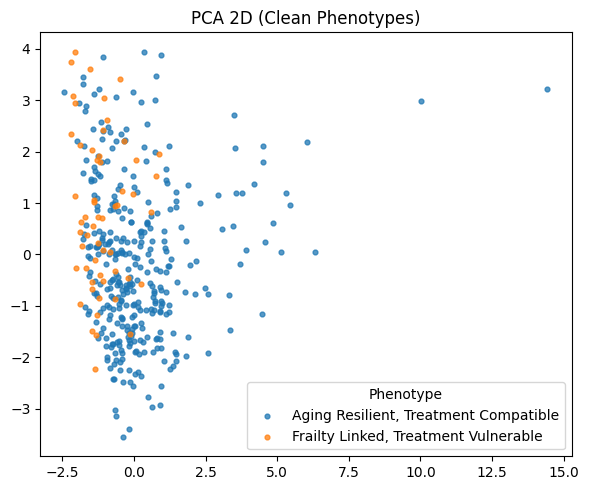

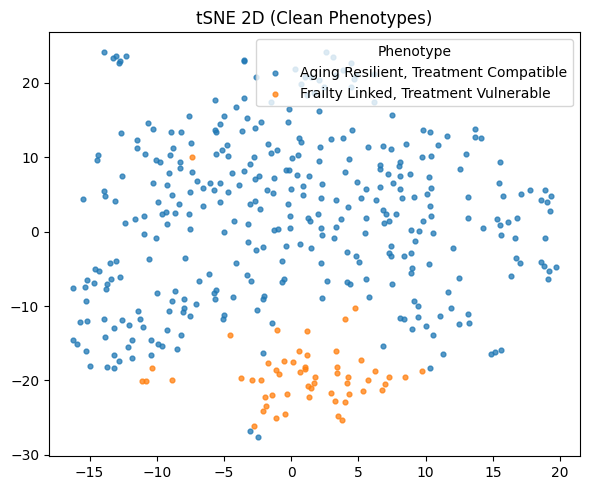

In [27]:
### Cell 7 (updated) ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Work on the full cohort with final phenotypes
df_main = df.copy()

if "Phenotype_K" not in df_main.columns:
    raise ValueError("Phenotype_K not found in df_main. Make sure Cell 6 (clustering) has been run.")

labels_for_plot = df_main["Phenotype_K"].values

# Build numeric and categorical subsets from the pruned feature lists
num_df = df_main[num_cols_final].copy() if len(num_cols_final) > 0 else None
cat_df = df_main[cat_cols_final].copy() if len(cat_cols_final) > 0 else None

# Impute numeric
if num_df is not None:
    for c in num_cols_final:
        num_df[c] = pd.to_numeric(num_df[c], errors="coerce")
    num_df = num_df.fillna(num_df.median())

# Impute categorical
if cat_df is not None:
    cat_df = cat_df.astype(str).fillna("__NA__")

# Scale and encode
blocks = []
if num_df is not None and num_df.shape[1] > 0:
    scaler = StandardScaler()
    X_num = scaler.fit_transform(num_df.values.astype(float))
    blocks.append(X_num)

if cat_df is not None and cat_df.shape[1] > 0:
    # Use sparse_output=False to be compatible with your sklearn version
    oh = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_cat = oh.fit_transform(cat_df.values)
    blocks.append(X_cat)

if len(blocks) == 0:
    raise ValueError("No numeric or categorical features available for embedding.")

X_mix = np.hstack(blocks)
print("Mixed embedding matrix shape:", X_mix.shape)

# Phenotype label names (cover up to 3 clusters gracefully)
phenotype_names = {
    0: "Aging Resilient, Treatment Compatible",
    1: "Frailty Linked, Treatment Vulnerable",
    2: "Additional Phenotype"
}

def _scatter_2d(Z, labels, title, out_png):
    plt.figure(figsize=(6, 5))
    unique_labels = np.unique(labels)
    for k in unique_labels:
        sel = labels == k
        label_name = phenotype_names.get(int(k), f"Phenotype {k}")
        plt.scatter(Z[sel, 0], Z[sel, 1], s=12, alpha=0.75, label=label_name)
    plt.title(title)
    plt.legend(title="Phenotype")
    plt.tight_layout()
    plt.savefig(OUT_DIR / out_png, dpi=150)
    plt.show()

# PCA
pca = PCA(n_components=2, random_state=7)
Z_pca = pca.fit_transform(X_mix)
_scatter_2d(Z_pca, labels_for_plot, "PCA 2D (Clean Phenotypes)", "pca_clean_umap_kmeans.png")

# t-SNE
tsne = TSNE(n_components=2, random_state=7, init="pca", learning_rate="auto")
Z_tsne = tsne.fit_transform(X_mix)
_scatter_2d(Z_tsne, labels_for_plot, "tSNE 2D (Clean Phenotypes)", "tsne_clean_umap_kmeans.png")


In [28]:
### Cell 8 ###
# Numeric median summaries
if len(num_cols_final) > 0:
    num_summary = df_main.groupby("Phenotype_K")[num_cols_final].median().T
    print("Numeric medians by phenotype:")
    display(num_summary)
else:
    print("No numeric features kept for summary.")

# Categorical percentage summaries
cat_summary = {}
for c in cat_cols_final:
    cat_summary[c] = df_main.groupby("Phenotype_K")[c].value_counts(normalize=True).unstack().fillna(0)

if len(cat_summary) > 0:
    cat_summary_df = pd.concat(cat_summary, axis=0)
    print("Categorical distributions by phenotype:")
    display(cat_summary_df)
else:
    print("No categorical features kept for summary.")

Numeric medians by phenotype:


Phenotype_K,0,1
adr_ctcae_grade,1.285714,1.285714
treatment_line_n,1.000000,1.000000
transfusions_total_n,0.000000,0.000000
active_principles_n,2.000000,2.000000
adr_n_grado1,1.000000,1.000000
observation_days,466.000000,394.000000
ordinary_hospitalizations_n,0.000000,0.000000
adr_n_tot,3.000000,1.000000
adr_n_grado3,0.000000,0.000000
adr_outcome,3.080128,3.080128


Categorical distributions by phenotype:


Absent / No   Present / Yes  \
                                Phenotype_K                                 
dyslipidemia                    0                0.893372        0.106628   
                                1                0.928571        0.071429   
white_blood_cells_range         0                     NaN             NaN   
                                1                     NaN             NaN   
hypertension                    0                0.654179        0.345821   
                                1                0.750000        0.250000   
observation_end_reason          0                     NaN             NaN   
                                1                     NaN             NaN   
surgical_intervention           0                0.449568        0.550432   
                                1                0.625000        0.375000   
neutrophils_percent_range       0                     NaN             NaN   
                                1                     NaN             NaN   
dpyd_genotype_known             0                     NaN             NaN   
                                1                     NaN             NaN   
dpyd_genotype_type              0                     NaN             NaN   
                                1                     NaN             NaN   
alcohol_consumption             0                     NaN             NaN   
                                1                     NaN             NaN   
smoking_status_detail           0                     NaN             NaN   
                                1                     NaN             NaN   
platelet_count_range            0                     NaN             NaN   
                                1                     NaN             NaN   
education_level                 0                     NaN             NaN   
                                1                     NaN             NaN   
tumor_stage_roman               0                     NaN             NaN   
                                1                     NaN             NaN   
red_blood_cells_range           0                     NaN             NaN   
                                1                     NaN             NaN   
end_reason_other_any_line       0                0.547550        0.452450   
                                1                0.750000        0.250000   
surgery_complications           0                     NaN             NaN   
                                1                     NaN             NaN   
tumor_stage_tnm                 0                     NaN             NaN   
                                1                     NaN             NaN   
creatinine_range                0                     NaN             NaN   
                                1                     NaN             NaN   
hemoglobin_range                0                     NaN             NaN   
end_reason_progression_any_line 0                0.789625        0.210375   
                                1                0.928571        0.071429   
direct_bilirubin_range          0                     NaN             NaN   
                                1                     NaN             NaN   

                                                 -1.0       0.0       1.0  \
                                Phenotype_K                                 
dyslipidemia                    0                 NaN       NaN       NaN   
                                1                 NaN       NaN       NaN   
white_blood_cells_range         0            0.011765  0.082353  0.817647   
                                1            0.979592  0.000000  0.020408   
hypertension                    0                 NaN       NaN       NaN   
                                1                 NaN       NaN       NaN   
observation_end_reason          0                 NaN       NaN       NaN   
                                1        

KM data shape: (231, 3)
    survival_days  Overall_Survival  Phenotype_K
1            87.0                 1            0
4           217.0                 0            1
7           694.0                 1            0
8           432.0                 0            0
11           31.0                 1            0
Aging Resilient, Treatment Compatible: median survival = 1050.0 days
Frailty Linked, Treatment Vulnerable: median survival = 895.0 days


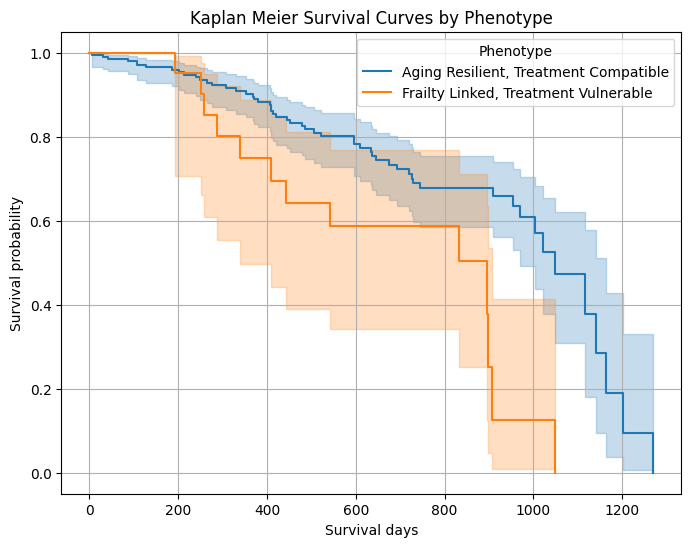

Death rate comparison across phenotypes (0 = alive, 1 = death):
Overall_Survival         0         1
Phenotype_K                         
0                 0.740385  0.259615
1                 0.434783  0.565217
Log rank test p value (Phenotype 0 vs 1): 0.003079463863048191


In [29]:
### Cell 9 ###
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Merge with outcome dataset
df_outcome = pd.read_csv(OUTCOME_PATH)

if id_col is None:
    raise ValueError("Patient ID column was not detected. Cannot merge outcomes reliably.")

merged_df = pd.merge(df_main, df_outcome, on=id_col, how="left")

# Check survival columns
required_cols = ["survival_days", "Overall_Survival"]
for rc in required_cols:
    if rc not in merged_df.columns:
        raise ValueError(f"Required outcome column '{rc}' not found after merge.")

df_km = merged_df[["survival_days", "Overall_Survival", "Phenotype_K"]].dropna()

print("KM data shape:", df_km.shape)
print(df_km.head())

# Define phenotype names only for those that exist
unique_phens = sorted(df_km["Phenotype_K"].unique())
phenotype_names_km = {k: phenotype_names.get(int(k), f"Phenotype {k}") for k in unique_phens}

kmf = KaplanMeierFitter()

plt.figure(figsize=(8, 6))
for phenotype in unique_phens:
    ph_data = df_km[df_km["Phenotype_K"] == phenotype]
    kmf.fit(
        durations=ph_data["survival_days"],
        event_observed=ph_data["Overall_Survival"],
        label=phenotype_names_km[phenotype]
    )
    kmf.plot_survival_function()

    median_surv = kmf.median_survival_time_
    print(f"{phenotype_names_km[phenotype]}: median survival = {median_surv} days")

plt.title("Kaplan Meier Survival Curves by Phenotype")
plt.xlabel("Survival days")
plt.ylabel("Survival probability")
plt.legend(title="Phenotype")
plt.grid(True)
plt.show()

# Death rate comparison
death_counts = df_km.groupby("Phenotype_K")["Overall_Survival"].value_counts(normalize=True).unstack(fill_value=0)
print("Death rate comparison across phenotypes (0 = alive, 1 = death):")
print(death_counts)

# Log rank test for K = 2 case only
if len(unique_phens) == 2:
    p0, p1 = unique_phens
    group0 = df_km[df_km["Phenotype_K"] == p0]
    group1 = df_km[df_km["Phenotype_K"] == p1]
    res = logrank_test(
        group0["survival_days"], group1["survival_days"],
        event_observed_A=group0["Overall_Survival"],
        event_observed_B=group1["Overall_Survival"]
    )
    print(f"Log rank test p value (Phenotype {p0} vs {p1}): {res.p_value}")
else:
    print("More than two phenotypes detected. Pairwise log rank tests can be added if needed.")


In [30]:
### Cell 10 ###
# Attach descriptive names
df_main = merged_df.copy()

# Rebuild names based on actual unique labels
unique_phens = sorted(df_main["Phenotype_K"].dropna().unique())
phenotype_names_final = {
    k: phenotype_names.get(int(k), f"Phenotype {k}") for k in unique_phens
}

df_main["Phenotype_Name"] = df_main["Phenotype_K"].map(phenotype_names_final)

print(df_main[[id_col, "Phenotype_K", "Phenotype_Name"]].head())

# Save updated phenotypes with outcomes for reporting
df_main.to_csv(OUT_DIR / "phase3_phenotypes_main_umap_kmeans.csv", index=False)
print("Saved:", OUT_DIR / "phase3_phenotypes_main_umap_kmeans.csv")

                           patient_id  Phenotype_K  \
0                       10_AO San Pio            0   
1               10_AORN A. Cardarelli            0   
2  10_AORN Monaldi – Cotugno - C.T.O.            0   
3        10_AORN San Giuseppe Moscati            0   
4  10_AORN Sant’Anna e San Sebastiano            1   

                          Phenotype_Name  
0  Aging Resilient, Treatment Compatible  
1  Aging Resilient, Treatment Compatible  
2  Aging Resilient, Treatment Compatible  
3  Aging Resilient, Treatment Compatible  
4   Frailty Linked, Treatment Vulnerable  
Saved: C:\Users\HP\OneDrive\Desktop\VERO_code\Phase_3\phase3_outputs\phase3_phenotypes_main_umap_kmeans.csv


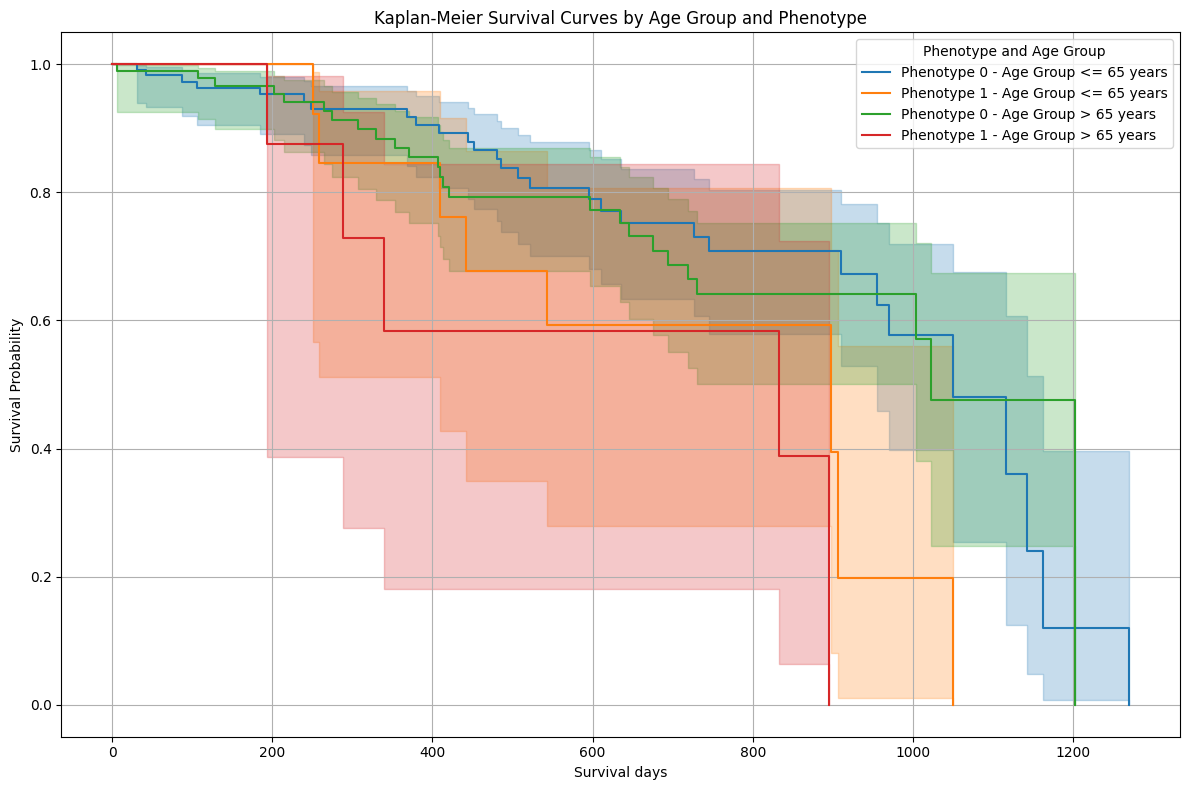

Death rate comparison across phenotypes (0 = alive, 1 = death):
Overall_Survival         0         1
Phenotype_K                         
0                 0.740385  0.259615
1                 0.434783  0.565217


UnboundLocalError: cannot access local variable 'survival_table' where it is not associated with a value

In [18]:
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Step 1: Load the age group data from the path you provided
age_group_data_path = "C:/Users/HP/OneDrive/Desktop/VERO_code/Phase_1/data/processed/cleaned_data.xlsx"  # Replace with correct path
age_group_df = pd.read_excel(age_group_data_path, sheet_name="Sheet1")  # Modify sheet_name if needed

# Step 2: Merge the age group data with the existing dataset (df_main)
merged_df = pd.merge(df_main, age_group_df, on="patient_id", how="left")

# Step 3: Check if the required columns are present
required_cols = ["survival_days", "Overall_Survival", "Phenotype_K", "age_group"]
for rc in required_cols:
    if rc not in merged_df.columns:
        raise ValueError(f"Required outcome column '{rc}' not found after merge.")

# Step 4: Filter out rows with missing values in survival, phenotype, or age group columns
df_km = merged_df[["survival_days", "Overall_Survival", "Phenotype_K", "age_group"]].dropna()

# Step 5: Define phenotype names only for those that exist
unique_phens = sorted(df_km["Phenotype_K"].unique())
phenotype_names_km = {k: f"Phenotype {k}" for k in unique_phens}  # Adjust if you have predefined names

# Step 6: Set up Kaplan-Meier Fitter
kmf = KaplanMeierFitter()

# Step 7: Create the Kaplan-Meier plot
plt.figure(figsize=(12, 8))

# Step 8: Loop through age groups and phenotypes to plot KM curves
for age_group in df_km['age_group'].unique():
    for phenotype in unique_phens:
        # Filter data for this age group and phenotype
        group_data = df_km[(df_km['age_group'] == age_group) & (df_km['Phenotype_K'] == phenotype)]
        
        # Define survival time and event indicator
        T = group_data['survival_days']  # Adjust column name for survival time
        E = group_data['Overall_Survival']   # Adjust column name for survival status
        
        # Fit Kaplan-Meier estimator
        kmf.fit(T, event_observed=E, label=f'{phenotype_names_km[phenotype]} - Age Group {age_group}')
        
        # Plot the survival curve for this group
        kmf.plot_survival_function(ci_show=True)

# Step 9: Customize plot
plt.title('Kaplan-Meier Survival Curves by Age Group and Phenotype')
plt.xlabel('Survival days')
plt.ylabel('Survival Probability')
plt.legend(title='Phenotype and Age Group')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 10: Death rate comparison across phenotypes
death_counts = df_km.groupby("Phenotype_K")["Overall_Survival"].value_counts(normalize=True).unstack(fill_value=0)
print("Death rate comparison across phenotypes (0 = alive, 1 = death):")
print(death_counts)

# Step 11: Log-rank test for K = 2 case only (between age groups for a specific phenotype)
if len(unique_phens) == 2:
    p0, p1 = unique_phens
    group0 = df_km[(df_km['Phenotype_K'] == p0) & (df_km['age_group'] == '<=65')]
    group1 = df_km[(df_km['Phenotype_K'] == p1) & (df_km['age_group'] == '>65')]
    
    res = logrank_test(
        group0['survival_days'], group1['survival_days'],
        event_observed_A=group0['Overall_Survival'],
        event_observed_B=group1['Overall_Survival']
    )
    print(f"Log-rank test p value (Phenotype {p0} vs {p1} between age groups): {res.p_value}")
else:
    print("More than two phenotypes detected. Pairwise log rank tests can be added if needed.")


KM data shape: (231, 4)
    survival_days  Overall_Survival  Phenotype_K    age_group
1            87.0                 1            0  <= 65 years
4           217.0                 0            1   > 65 years
7           694.0                 1            0   > 65 years
8           432.0                 0            0  <= 65 years
11           31.0                 1            0  <= 65 years
Death rate comparison across phenotypes (0 = alive, 1 = death):
Overall_Survival         0         1
Phenotype_K                         
0                 0.740385  0.259615
1                 0.434783  0.565217
Skipping Log-rank test for Phenotype 0 vs 1 due to empty group data.


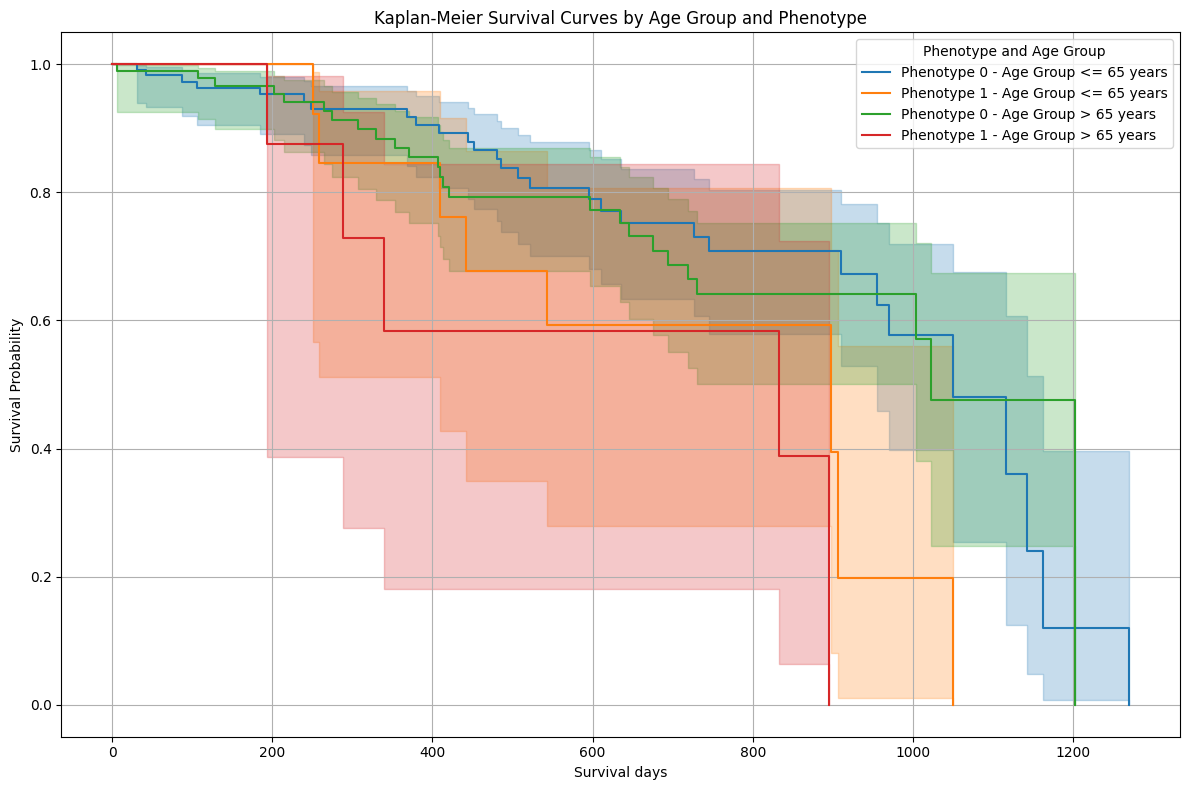

In [36]:
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Step 1: Load only the 'age_group' column from the external file
age_group_data_path = "C:/Users/HP/OneDrive/Desktop/VERO_code/Phase_1/data/processed/cleaned_data.xlsx"
age_group_df = pd.read_excel(age_group_data_path, usecols=["patient_id", "age_group"])  # Only load 'patient_id' and 'age_group'

# Step 2: Merge the 'age_group' data with the existing merged_df
# Assuming 'patient_id' is the common column for merging
merged_df = pd.merge(df_main, age_group_df, on="patient_id", how="left")

# Step 3: Check if the required columns are present after merge
required_cols = ["survival_days", "Overall_Survival", "Phenotype_K", "age_group"]
for rc in required_cols:
    if rc not in merged_df.columns:
        raise ValueError(f"Required outcome column '{rc}' not found after merge.")

# Step 4: Filter the data, ensuring no NaN values in survival, phenotype, or age group columns
df_km = merged_df[["survival_days", "Overall_Survival", "Phenotype_K", "age_group"]].dropna()

print("KM data shape:", df_km.shape)
print(df_km.head())

# Define phenotype names only for those that exist
unique_phens = sorted(df_km["Phenotype_K"].unique())
phenotype_names_km = {k: f"Phenotype {k}" for k in unique_phens}  # Adjust if you have predefined names

# Set up Kaplan-Meier Fitter
kmf = KaplanMeierFitter()

# Step 5: Create the Kaplan-Meier plot
plt.figure(figsize=(12, 8))

# Step 6: Loop through age groups and phenotypes to plot KM curves
for age_group in df_km['age_group'].unique():
    for phenotype in unique_phens:
        # Filter data for this age group and phenotype
        group_data = df_km[(df_km['age_group'] == age_group) & (df_km['Phenotype_K'] == phenotype)]
        
        # Skip empty groups
        if group_data.empty:
            print(f"Skipping {phenotype_names_km[phenotype]} for Age Group {age_group} (no data)")
            continue
        
        # Define survival time and event indicator
        T = group_data['survival_days']  # Adjust column name for survival time
        E = group_data['Overall_Survival']   # Adjust column name for survival status
        
        # Fit Kaplan-Meier estimator
        kmf.fit(T, event_observed=E, label=f'{phenotype_names_km[phenotype]} - Age Group {age_group}')
        
        # Plot the survival curve for this group
        kmf.plot_survival_function(ci_show=True)

# Step 7: Customize plot
plt.title('Kaplan-Meier Survival Curves by Age Group and Phenotype')
plt.xlabel('Survival days')
plt.ylabel('Survival Probability')
plt.legend(title='Phenotype and Age Group')
plt.grid(True)
plt.tight_layout()

# Step 8: Save the plot to the specified path
output_path = r"C:\Users\HP\OneDrive\Desktop\VERO_code\Phase_3\phase3_outputs\kaplan_meier_survival_curves.png"
plt.savefig(output_path)

# Step 9: Death rate comparison across phenotypes
death_counts = df_km.groupby("Phenotype_K")["Overall_Survival"].value_counts(normalize=True).unstack(fill_value=0)
print("Death rate comparison across phenotypes (0 = alive, 1 = death):")
print(death_counts)

# Step 10: Log-rank test for K = 2 case only (between age groups for a specific phenotype)
if len(unique_phens) == 2:
    p0, p1 = unique_phens
    group0 = df_km[(df_km['Phenotype_K'] == p0) & (df_km['age_group'] == '<=65')]
    group1 = df_km[(df_km['Phenotype_K'] == p1) & (df_km['age_group'] == '>65')]
    
    # Ensure both groups have data before running log-rank test
    if not group0.empty and not group1.empty:
        res = logrank_test(
            group0['survival_days'], group1['survival_days'],
            event_observed_A=group0['Overall_Survival'],
            event_observed_B=group1['Overall_Survival']
        )
        print(f"Log-rank test p value (Phenotype {p0} vs {p1} between age groups): {res.p_value}")
    else:
        print(f"Skipping Log-rank test for Phenotype {p0} vs {p1} due to empty group data.")
else:
    print("More than two phenotypes detected. Pairwise log rank tests can be added if needed.")


In [35]:
df_km.info()

<class 'pandas.core.frame.DataFrame'>
Index: 231 entries, 1 to 401
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   survival_days     231 non-null    float64
 1   Overall_Survival  231 non-null    int64  
 2   Phenotype_K       231 non-null    int32  
dtypes: float64(1), int32(1), int64(1)
memory usage: 6.3 KB
